In [44]:
# Common imports
import pandas as pd
import numpy as np
import os

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import seaborn as sns
import geopandas

#stats
import statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [45]:
#input local file path to CRyPTIC tables
file_path='../cryptic_data_analysis/data_tables/cryptic-analysis-group'

In [46]:
#read in files
phenotypes = pd.read_pickle(file_path+"/UKMYC_PHENOTYPES.pkl.gz")
phenotypes.reset_index(level=1, inplace=True)
phenotypes.reset_index(level=0, inplace=True)
phenotypes=phenotypes.loc[phenotypes['BELONGS_GPI']==True]
fq_phenotypes=phenotypes.loc[phenotypes.DRUG.isin(['LEV','MXF'])]

mutations=pd.read_pickle(file_path+"/MUTATIONS_GPI.pkl.gz")
mutations.reset_index(inplace=True)
gyrase_mutations=mutations.loc[mutations.GENE.isin(['gyrA','gyrB'])]
gyrase_mutations["GENEMUT"]=gyrase_mutations['GENE'].astype('str')+gyrase_mutations['MUTATION']

<ipython-input-46-b37fd6fd3a47>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gyrase_mutations["GENEMUT"]=gyrase_mutations['GENE'].astype('str')+gyrase_mutations['MUTATION']


In [47]:
#define list of lineage mutations not to include
#ref for lineage mutations: Miotto ERJ 2017
lin_muts=['gyrAS95T','gyrAE21Q','gyrAT80A','gyrAA90G','gyrAG247S','gyrAA384V',
             'gyrAG668D','gyrAL712V', 'gyrAS250A','gyrAR252L','gyrAL398F','gyrAA463S','gyrAD639A','gyrAV742L',
              'gyrBV301L','gyrBM291I','gyrBA403S']

In [48]:
#make dataframes of FQ resistant and suscpetible phenotpyes
fq_s=fq_phenotypes.loc[fq_phenotypes.BINARY_PHENOTYPE=='S'].UNIQUEID.unique()
fq_r=fq_phenotypes.loc[fq_phenotypes.BINARY_PHENOTYPE=='R'].UNIQUEID.unique()

In [49]:
#remove lineage mutations, filter fails and null calls
gyrase_mutations=gyrase_mutations.loc[(-gyrase_mutations.GENEMUT.isin(lin_muts))&(gyrase_mutations.IS_FILTER_PASS==True)
                                     &(gyrase_mutations.IS_NULL==False)]

#filter for mutations within gyrA QRDR (resisdues 74 to 113)
gyra_qrdr_muts=gyrase_mutations.loc[(gyrase_mutations.GENE=='gyrA')&(gyrase_mutations.POSITION>=74)&(gyrase_mutations.POSITION<=113)]

#filter for mutations within gyrB QRDR (resisdues 461 to 504)
gyrb_qrdr_muts=gyrase_mutations.loc[(gyrase_mutations.GENE=='gyrB')&(gyrase_mutations.POSITION>=461)&(gyrase_mutations.POSITION<=504)]



In [50]:
#make df of FQ S isolates with mutations in gyrA/B QRDR
gyra_qrdr_s_muts=gyra_qrdr_muts.loc[gyra_qrdr_muts.UNIQUEID.isin(fq_s)]
gyrb_qrdr_s_muts=gyrb_qrdr_muts.loc[gyrb_qrdr_muts.UNIQUEID.isin(fq_s)]
#make df of FQ R isolates with mutations in gyrA/B QRDR
gyra_qrdr_r_muts=gyra_qrdr_muts.loc[gyra_qrdr_muts.UNIQUEID.isin(fq_r)]
gyrb_qrdr_r_muts=gyrb_qrdr_muts.loc[gyrb_qrdr_muts.UNIQUEID.isin(fq_r)]

In [51]:
#fq resistant isolates with gyrA QRDR mutation
gyra_qrdr=gyra_qrdr_r_muts.loc[gyra_qrdr_r_muts.IS_SYNONYMOUS==False].UNIQUEID.nunique()
print(gyra_qrdr)

1723


In [52]:
#fq resistant isolates with gyrB QRDR mutation only
gyrb_qrdr=gyrb_qrdr_r_muts.loc[(-gyrb_qrdr_r_muts.UNIQUEID.isin(gyra_qrdr_r_muts.loc[gyra_qrdr_r_muts.IS_SYNONYMOUS==False].UNIQUEID.unique()))
                    &(gyrb_qrdr_r_muts.IS_SYNONYMOUS==False)].UNIQUEID.nunique()
print(gyrb_qrdr)

49


In [53]:
#number of fq resistant isolates with a dna gyrase mutation
n_gyrase_mutations=gyrase_mutations.loc[(gyrase_mutations.IS_SYNONYMOUS==False)&(gyrase_mutations.UNIQUEID.isin(fq_r))].UNIQUEID.nunique()

<ipython-input-54-b840b733d0b2>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('mutation_location.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


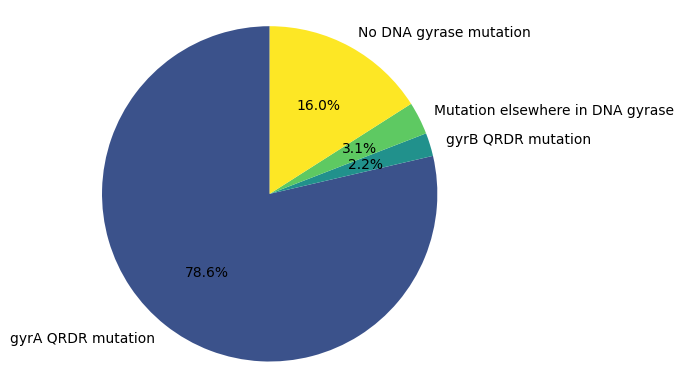

In [54]:
# Pie chart
labels = 'gyrA QRDR mutation', 'gyrB QRDR mutation', 'Mutation elsewhere in DNA gyrase', 'No DNA gyrase mutation'
sizes = [gyra_qrdr, gyrb_qrdr, n_gyrase_mutations-(gyra_qrdr+gyrb_qrdr), 2191-n_gyrase_mutations]


fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=90, colors=['#3b528b','#21918c','#5ec962','#fde725'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('mutation_location.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')

In [55]:
#make dict for y axis positions of mutant amino acids
aas_dict={'A': 1,'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7,
                 'I':8, 'K':9, 'L':10, 'M':11, 'N':12,'P':13, 
                  'Q':14, 'R':15, 'S':16, 'T': 17,'V': 18, 
                  'W':19, 'Y':20, 'promoter SNP':21,'indel':22
                 }

#define functions for plotting graphs
def get_new_aa(index):
    '''Given an index from dataframe.MUTATION.value_counts(), returns mutant amino acid (or promoter SNP or indel status)'''
    new_aa=[]
    for item in index:
        if item[-1] in aas_dict.keys():
            new_aa.append(item[-1])
        elif item[-1] in ['a','t','c','g']:
             new_aa.append("promoter SNP")
        elif item[-1] == 'l':
            new_aa.append("indel")
    
    return(new_aa)

def get_aa_values(aa_list):
    '''Given a list of amino acids, returns a list of their y axis positions from aas_dict'''
    aa_values_list=[]
    for aa in aa_list:
        aa_values_list.append(aas_dict[aa])
    return aa_values_list

def get_position(index):
    '''Given an index from dataframe.MUTATION.value_counts(), returns position of the mutation in rpoB'''
    pos=[]
    for item in index:
        if item[-1] in aas_dict.keys():
            pos.append(int(item[1:-1]))
        elif item[-1] in ['a','t','c','g']:
            pos.append(int(item[1:-1]))
        elif item[-1] in ['l']:
            pos.append(int(item[0:-6]))
    
    return(pos)

In [56]:
#value_counts of non-synonymous mutations within the gyrA QRDR in R and S isolates
gyra_qrdr_s_vcs=gyra_qrdr_s_muts.MUTATION.value_counts()
gyra_qrdr_r_vcs=gyra_qrdr_r_muts.MUTATION.value_counts()




[18, 6, 1, 13, 12, 3, 20, 7, 1, 16, 12, 2, 15, 1, 13, 1, 18, 6, 15, 2, 12, 9, 16, 18, 8, 20, 16, 1, 10, 17, 6] A90V     2.081756
D94G     1.599167
D94A     0.577214
S91P     0.331188
D94N     0.274413
D111D    0.236563
D94Y     0.113550
D94H     0.104088
G88A     0.066238
S104S    0.056775
D89N     0.037850
G88C     0.028388
L105R    0.028388
A90A     0.018925
P102P    0.018925
S95A     0.018925
V97V     0.018925
D111G    0.009463
R75R     0.009463
G112C    0.009463
N83N     0.009463
E79K     0.009463
A74S     0.009463
D94V     0.009463
M99I     0.009463
Y93Y     0.009463
P108S    0.009463
A100A    0.009463
L96L     0.009463
A74T     0.009463
G88G     0.009463
Name: MUTATION, dtype: float64
[6, 18, 12, 1, 13, 20, 7, 2, 12, 6, 1, 16, 1, 4, 17, 3, 15, 5, 18] D94G     34.778640
A90V     21.268827
D94N      7.028754
D94A      5.476951
S91P      4.016431
D94Y      3.240529
D94H      1.962574
G88C      1.049749
D89N      0.410771
D89G      0.136924
S95A      0.136924
A74S      0.136924
G88A 

<ipython-input-57-107a6572373b>:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('qrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


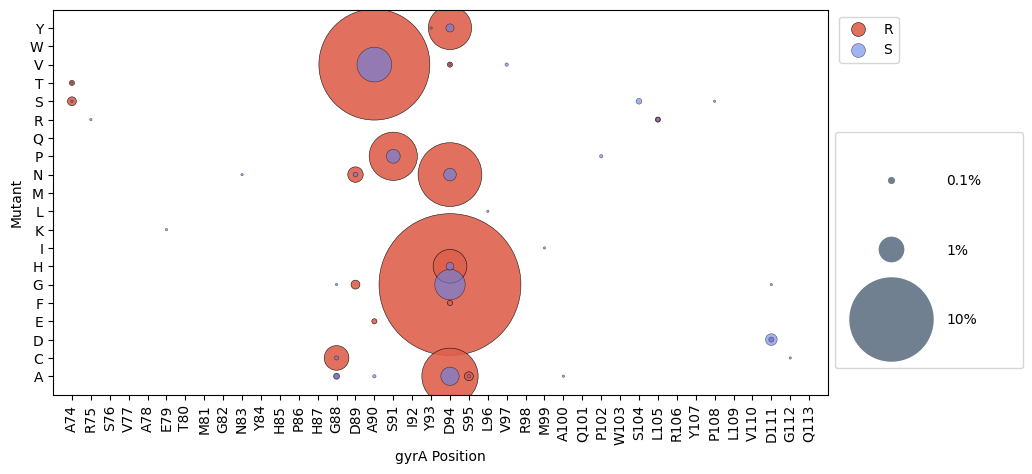

In [57]:
#make graph showing difference in gyrA QRDR mutational profile for R and S isolates

plt.figure(figsize=(10,5))

x1=get_position(gyra_qrdr_s_vcs.index)
y1=get_aa_values(get_new_aa(gyra_qrdr_s_vcs.index))
s1=((gyra_qrdr_s_vcs/len(fq_s)))
x2=get_position(gyra_qrdr_r_vcs.index)
y2=get_aa_values(get_new_aa(gyra_qrdr_r_vcs.index))
s2=((gyra_qrdr_r_vcs/len(fq_r)))

print(y1,s1*100)
print(y2,s2*100)

scatter1=plt.scatter(x2,y2,s=s2*30000,
                     color='#de604d', alpha=0.9, edgecolors='k', linewidth=0.4,
                     label='R')
scatter2=plt.scatter(x1,y1,s=s1*30000, 
                     color='#6282ea', alpha=0.6, edgecolors='k', linewidth=0.4,
                     label='S')


plt.xlim([73, 114])    
plt.ylim([0, 21]) 
plt.xticks(range(74,114), ['A74','R75','S76','V77','A78','E79','T80', 'M81','G82','N83','Y84','H85',
                            'P86','H87', 'G88', 'D89', 'A90', 'S91','I92','Y93','D94','S95','L96','V97',
                            'R98','M99','A100', 'Q101', 'P102','W103','S104', 'L105','R106', 'Y107',
                            'P108', 'L109', 'V110', 'D111', 'G112', 'Q113'],rotation='vertical')
plt.xlabel('gyrA Position')
plt.ylabel('Mutant')

index_list=[]
for a in aas_dict.keys():
    index_list.append(a)
plt.yticks(range(1,21), index_list[:-2])


legend1 = plt.legend( bbox_to_anchor=(1.1, 1))
legend1.legendHandles[0]._sizes = [100]
legend1.legendHandles[1]._sizes = [100]
plt.gca().add_artist(legend1)




line1 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.001*30000)/3.14159))*2, 
                     markerfacecolor="slategray")
line2 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.01*30000)/3.14159))*2, 
                     markerfacecolor="slategray")
line3 = lines.Line2D(range(1), range(1), color="white", marker='o',markersize=(np.sqrt((0.1*30000)/3.14159))*2, 
                     markerfacecolor="slategray")
plt.legend((line1,line2,line3),('0.1%','1%', '10%'),numpoints=1, bbox_to_anchor=(1, 0.7), 
           labelspacing=4, borderpad=3, handletextpad=3)


plt.savefig('qrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')

[12, 3, 12, 18, 17, 17, 12, 8, 15, 1, 3, 10, 17, 8, 18, 18, 12, 1, 10, 15, 18, 15, 1, 5, 15, 1, 8, 3, 6, 16, 16, 9] D461N    0.141938
E501D    0.123013
T500N    0.056775
A504V    0.047313
N499T    0.047313
I493T    0.037850
N499N    0.037850
T500I    0.018925
R492R    0.018925
T500A    0.018925
N499D    0.018925
L481L    0.018925
A504T    0.018925
N499I    0.009463
I486V    0.009463
E501V    0.009463
K498N    0.009463
G470A    0.009463
L497L    0.009463
R482R    0.009463
D461V    0.009463
R471R    0.009463
D494A    0.009463
F475F    0.009463
R495R    0.009463
D461A    0.009463
I486I    0.009463
D494D    0.009463
D494G    0.009463
P480S    0.009463
N499S    0.009463
N499K    0.009463
Name: MUTATION, dtype: float64 [12, 3, 17, 3, 12, 17, 18, 16, 9, 8, 2, 10, 18, 7, 1, 8, 1] D461N    0.958466
E501D    0.912825
N499T    0.410771
N499D    0.273848
T500N    0.273848
A504T    0.228206
A504V    0.228206
N499S    0.182565
N499K    0.091283
T500I    0.045641
G470C    0.045641
I486L    0.045641
E

<ipython-input-58-ca342bc70b31>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('gyrb_qrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


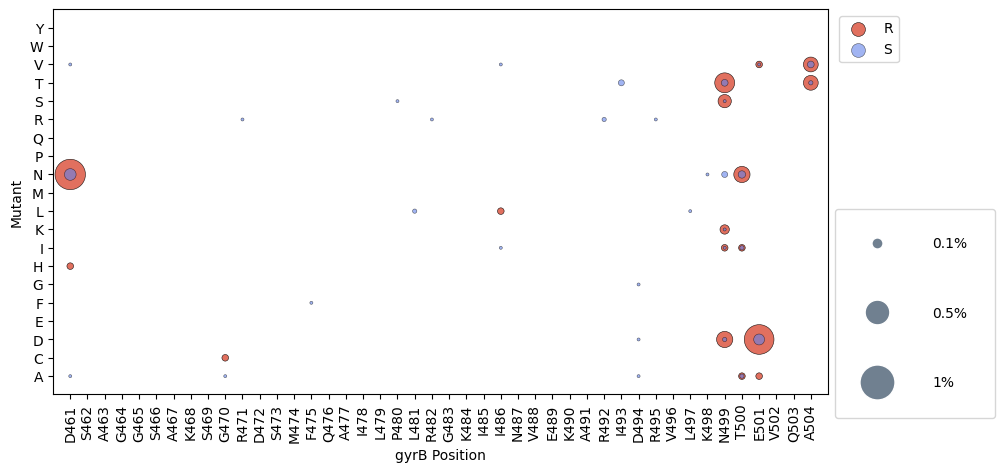

In [58]:
#value_counts of gyrB mutations within the QRDR in R and S isolates
gyrb_qrdr_s_vcs=gyrb_qrdr_s_muts.MUTATION.value_counts()
gyrb_qrdr_r_vcs=gyrb_qrdr_r_muts.MUTATION.value_counts()


#make graph showing difference in rpoB RRDR mutational profile for RMR and MDR isolates

plt.figure(figsize=(10,5))

x1=get_position(gyrb_qrdr_s_vcs.index)
y1=get_aa_values(get_new_aa(gyrb_qrdr_s_vcs.index))
s1=((gyrb_qrdr_s_vcs/len(fq_s)))
x2=get_position(gyrb_qrdr_r_vcs.index)
y2=get_aa_values(get_new_aa(gyrb_qrdr_r_vcs.index))
s2=((gyrb_qrdr_r_vcs/len(fq_r)))
print(y1,s1*100,y2,s2*100)
scatter1=plt.scatter(x2,y2,s=s2*50000,
                     color='#de604d', alpha=0.9, edgecolors='k', linewidth=0.4,
                     label='R')
scatter2=plt.scatter(x1,y1,s=s1*50000, 
                     color='#6282ea', alpha=0.6, edgecolors='k', linewidth=0.4,
                     label='S')


plt.xlim([460, 505])    
plt.ylim([0, 21]) 


plt.xticks(range(461,505), ['D461','S462','A463','G464','G465','S466','A467', 'K468','S469','G470','R471','D472',
                            'S473','M474', 'F475', 'Q476', 'A477', 'I478','L479','P480','L481','R482','G483','K484','I485',
                            'I486', 'N487', 'V488', 'E489', 'K490', 'A491','R492','I493','D494','R495','V496',
                           'L497','K498','N499','T500','E501','V502','Q503','A504'],rotation='vertical')

plt.xlabel('gyrB Position')
plt.ylabel('Mutant')

index_list=[]
for a in aas_dict.keys():
    index_list.append(a)
plt.yticks(range(1,21), index_list[:-2])


legend1 = plt.legend( bbox_to_anchor=(1.1, 1))
legend1.legendHandles[0]._sizes = [100]
legend1.legendHandles[1]._sizes = [100]
plt.gca().add_artist(legend1)




line1 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.001*50000)/3.14159))*2, 
                     markerfacecolor="slategray")
line2 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.005*50000)/3.14159))*2, 
                     markerfacecolor="slategray")
line3 = lines.Line2D(range(1), range(1), color="white", marker='o',markersize=(np.sqrt((0.01*50000)/3.14159))*2, 
                     markerfacecolor="slategray")
plt.legend((line1,line2,line3),('0.1%','0.5%', '1%'),numpoints=1, bbox_to_anchor=(1, 0.5), 
           labelspacing=4, borderpad=2, handletextpad=3)


plt.savefig('gyrb_qrdr_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')




In [59]:
#make dataframes of mutations in gyra (non qrdr) and gyrb genes in R and S isolates
gyra_muts=gyrase_mutations.loc[(gyrase_mutations.GENE=='gyrA')&((gyrase_mutations.POSITION<74)|(gyrase_mutations.POSITION>113))]
gyrb_muts=gyrase_mutations.loc[(gyrase_mutations.GENE=='gyrB')]
gyra_s_muts=gyra_muts.loc[gyra_muts.UNIQUEID.isin(fq_s)]
gyra_r_muts=gyra_muts.loc[gyra_muts.UNIQUEID.isin(fq_r)]
gyrb_s_muts=gyrb_muts.loc[gyrb_muts.UNIQUEID.isin(fq_s)]
gyrb_r_muts=gyrb_muts.loc[gyrb_muts.UNIQUEID.isin(fq_r)]

<ipython-input-60-0c24042aad88>:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('gyra_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


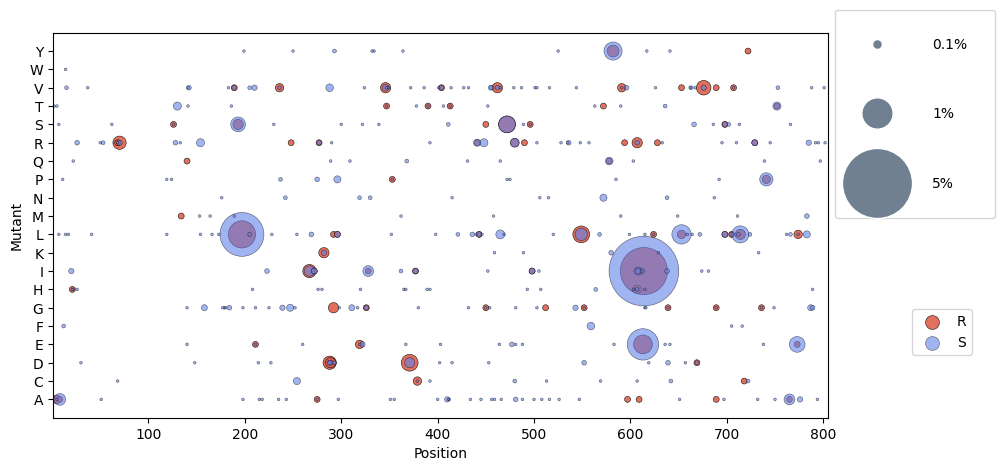

In [60]:
#value_counts of mutations outside QRDR in gyrA
gyra_s_vcs=gyra_s_muts.MUTATION.value_counts()
gyra_r_vcs=gyra_r_muts.MUTATION.value_counts()


#make graph showing difference in gyrA mutational profile outside QRDR for R and S isolates (QRDR muts removed for clarity)

plt.figure(figsize=(10,5))

x1=get_position(gyra_s_vcs.index)
y1=get_aa_values(get_new_aa(gyra_s_vcs.index))
s1=((gyra_s_vcs/len(fq_s)))
x2=get_position(gyra_r_vcs.index)
y2=get_aa_values(get_new_aa(gyra_r_vcs.index))
s2=((gyra_r_vcs/len(fq_r)))

scatter1=plt.scatter(x2,y2,s=s2*40000,
                     color='#de604d', alpha=0.9, edgecolors='k', linewidth=0.4,
                     label='R')
scatter2=plt.scatter(x1,y1,s=s1*40000, 
                     color='#6282ea', alpha=0.6, edgecolors='k', linewidth=0.4,
                     label='S')


plt.xlim([1, 805])    
plt.ylim([0, 21]) 

plt.xlabel('Position')
plt.ylabel('Mutant')

index_list=[]
for a in aas_dict.keys():
    index_list.append(a)
plt.yticks(range(1,21), index_list[:-2])


legend1 = plt.legend( bbox_to_anchor=(1.1, 0.3))
legend1.legendHandles[0]._sizes = [100]
legend1.legendHandles[1]._sizes = [100]
plt.gca().add_artist(legend1)




line1 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.001*40000)/3.14159))*2, 
                     markerfacecolor="slategray")
line2 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.01*40000)/3.14159))*2, 
                     markerfacecolor="slategray")
line3 = lines.Line2D(range(1), range(1), color="white", marker='o',markersize=(np.sqrt((0.05*40000)/3.14159))*2, 
                     markerfacecolor="slategray")
plt.legend((line1,line2,line3),('0.1%','1%', '5%'),numpoints=1, bbox_to_anchor=(1, 0.5), 
           labelspacing=4, borderpad=2, handletextpad=3)


plt.savefig('gyra_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


<ipython-input-61-cc33980a29d4>:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('gyrb_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')


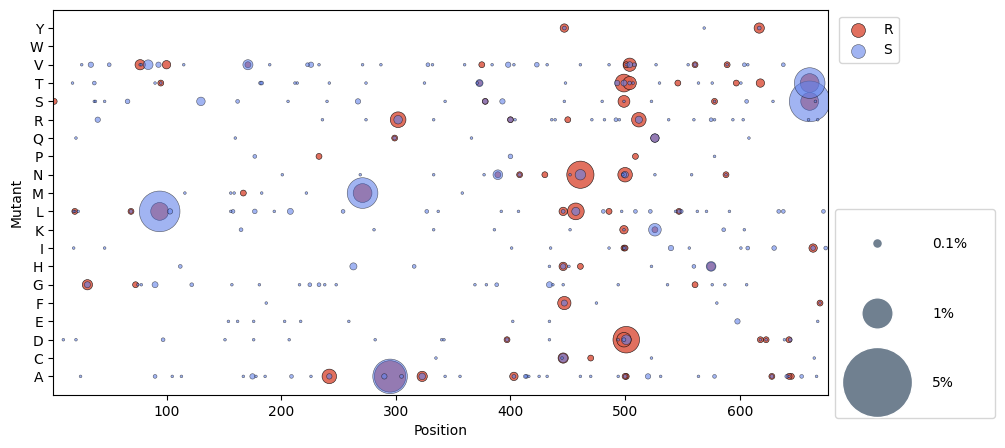

In [61]:
#value_counts of mutations in gyrB
gyrb_s_vcs=gyrb_s_muts.MUTATION.value_counts()
gyrb_r_vcs=gyrb_r_muts.MUTATION.value_counts()


#make graph showing difference in gyrB mutational profile for R and S isolates

plt.figure(figsize=(10,5))

x1=get_position(gyrb_s_vcs.index)
y1=get_aa_values(get_new_aa(gyrb_s_vcs.index))
s1=((gyrb_s_vcs/len(fq_s)))
x2=get_position(gyrb_r_vcs.index)
y2=get_aa_values(get_new_aa(gyrb_r_vcs.index))
s2=((gyrb_r_vcs/len(fq_r)))


scatter1=plt.scatter(x2,y2,s=s2*40000,
                     color='#de604d', alpha=0.9, edgecolors='k', linewidth=0.4,
                     label='R')
scatter2=plt.scatter(x1,y1,s=s1*40000, 
                     color='#6282ea', alpha=0.6, edgecolors='k', linewidth=0.4,
                     label='S')


plt.xlim([1, 677])    
plt.ylim([0, 21]) 

plt.xlabel('Position')
plt.ylabel('Mutant')

index_list=[]
for a in aas_dict.keys():
    index_list.append(a)
plt.yticks(range(1,21), index_list[:-2])


legend1 = plt.legend( bbox_to_anchor=(1.1, 1))
legend1.legendHandles[0]._sizes = [100]
legend1.legendHandles[1]._sizes = [100]
plt.gca().add_artist(legend1)




line1 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.001*40000)/3.14159))*2, 
                     markerfacecolor="slategray")
line2 = lines.Line2D(range(1), range(1), color="white", marker='o', markersize=(np.sqrt((0.01*40000)/3.14159))*2, 
                     markerfacecolor="slategray")
line3 = lines.Line2D(range(1), range(1), color="white", marker='o',markersize=(np.sqrt((0.05*40000)/3.14159))*2, 
                     markerfacecolor="slategray")
plt.legend((line1,line2,line3),('0.1%','1%', '5%'),numpoints=1, bbox_to_anchor=(1, 0.5), 
           labelspacing=4, borderpad=2, handletextpad=3)


plt.savefig('gyrb_mutations_fig.png', dpi=300, tightlayout=True, transparent=True, bbox_inches='tight')

